In [1]:
#import SparkSession
from pyspark.sql import SparkSession
#create spark object
spark=SparkSession.builder.appName('emb').getOrCreate()

In [2]:
#reading a file
df=spark.read.csv('br_lstm_data.csv',header=True,inferSchema=True)

In [3]:
df.count()

1096955

In [4]:
df = df.filter("page_category != ''")

In [5]:
df.select('page_category').distinct().count()

25

In [6]:
df.select('visitor_id').distinct().count()

104160

In [7]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

def page_udf(page):
    if page =='error':
        return 'others'
    elif page =='social':
        return 'others'
    else:
        return page
        
nissan_udf = udf(page_udf, StringType())

df_updated=df.withColumn("page_new", nissan_udf(df.page_category))

In [11]:
## filter converted visitors
##conv_visitors=[x[0] for x in df_updated.filter(df_updated['page_new']=='testdriveconfirmation').select('visitor_id').distinct().collect()]

In [12]:
# from pyspark.sql.types import IntegerType
# from pyspark.sql.functions import udf

# def is_converted(vis_id):
#     if vis_id in conv_visitors:
#         return 1
#     else:
#         return 0
        
# converted_udf = udf(is_converted, IntegerType())

# df_updated_1=df_updated.withColumn("is_converted", converted_udf(df_updated['visitor_id']))

In [8]:
df_updated.groupBy('is_converted').count().orderBy('count').show(10,False)

+------------+-------+
|is_converted|count  |
+------------+-------+
|1           |96955  |
|0           |1000000|
+------------+-------+



In [16]:
df_updated.filter(df_updated['is_converted']==1).select('visitor_id').distinct().count()

5782

In [17]:
df_updated.filter(df_updated['is_converted']==0).select('visitor_id').distinct().count()

98378

In [18]:
from pyspark.ml.feature import StringIndexer
import sys
from pyspark.sql.window import Window
import pyspark.sql.functions as func
from pyspark.sql.functions import  lag


In [15]:
# indexer = StringIndexer(inputCol="page_new", outputCol="categoryIndex")
# indexed_df = indexer.fit(df_updated).transform(df_updated)



In [19]:
#not considering session
w = Window.partitionBy(["visitor_id"]).orderBy('date_time_ts')

#replacing null values with drop

new_df=df_updated.withColumn("output", lag("page_new", -1, 'dropped').over(w))

In [20]:
new_df.count()

1096955

In [21]:
data=new_df.filter(new_df['page_new'] != new_df['output'])

In [22]:
data.count()

669879

In [23]:
new_data=data.select('visitor_id','page_new','output','is_converted', func.collect_list(data.page_new).over(w).alias('features'))


In [24]:
new_data.show(5,False)

+---------------------------------------+--------------+--------------+------------+-------------------------------------------------------------------+
|visitor_id                             |page_new      |output        |is_converted|features                                                           |
+---------------------------------------+--------------+--------------+------------+-------------------------------------------------------------------+
|1014693057261549843_9055106623262667991|homepage      |vehiclenew    |1           |[homepage]                                                         |
|1014693057261549843_9055106623262667991|vehiclenew    |specifications|1           |[homepage, vehiclenew]                                             |
|1014693057261549843_9055106623262667991|specifications|accessories   |1           |[homepage, vehiclenew, specifications]                             |
|1014693057261549843_9055106623262667991|accessories   |specifications|1          

In [25]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

slen = udf(lambda s: len(s), IntegerType())

new_data = new_data.withColumn("Length", slen(new_data.features))


In [139]:
# join_udf = udf(lambda x: " ".join(x))
# new_data=new_data.withColumn("processed_features", join_udf(new_data["features"]))

In [26]:
new_data.head(5)

[Row(visitor_id='1014693057261549843_9055106623262667991', page_new='homepage', output='vehiclenew', is_converted=1, features=['homepage'], Length=1),
 Row(visitor_id='1014693057261549843_9055106623262667991', page_new='vehiclenew', output='specifications', is_converted=1, features=['homepage', 'vehiclenew'], Length=2),
 Row(visitor_id='1014693057261549843_9055106623262667991', page_new='specifications', output='accessories', is_converted=1, features=['homepage', 'vehiclenew', 'specifications'], Length=3),
 Row(visitor_id='1014693057261549843_9055106623262667991', page_new='accessories', output='specifications', is_converted=1, features=['homepage', 'vehiclenew', 'specifications', 'accessories'], Length=4),
 Row(visitor_id='1014693057261549843_9055106623262667991', page_new='specifications', output='homepage', is_converted=1, features=['homepage', 'vehiclenew', 'specifications', 'accessories', 'specifications'], Length=5)]

In [27]:
lstm_df=new_data.select(['visitor_id','features','Length','is_converted'])

In [28]:
pd_df=lstm_df.toPandas()

In [29]:
import numpy as np

In [30]:
!pip install gensim

    100% |████████████████████████████████| 22.6MB 33kB/s 
    100% |████████████████████████████████| 1.4MB 564kB/s 
    100% |████████████████████████████████| 133kB 2.2MB/s 
    100% |████████████████████████████████| 4.1MB 184kB/s 
    100% |████████████████████████████████| 61kB 2.1MB/s 
    100% |████████████████████████████████| 194kB 1.6MB/s 
    100% |████████████████████████████████| 552kB 878kB/s 
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/cf/54/36/b003d8c2d26aadffc21f0677009ed53cf9575a97fc71fbba76
  Running setup.py bdist_wheel for bz2file ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/31/9c/20/996d65ca104cbca940b1b053299b68459391c01c774d073126
Successfully built smart-open bz2file
  Found existing installation: python-dateutil 2.7.0
    Uninstalling python-dateutil-2.7.0:
      Successfully uninstalled python-dateutil-2.7.0
You are using pip version 9.0.1, however version 9.0.3 is available.


In [32]:
!pip install nltk
import nltk

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [33]:
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
from random import sample
import pandas as pd

In [34]:
#creating max length variable
max_length=max(pd_df.Length)
print(max_length)

90


In [37]:
pd_df.head(20)

,visitor_id,features,Length,is_converted
0,1014693057261549843_9055106623262667991,[homepage],1,1
1,1014693057261549843_9055106623262667991,"[homepage, vehiclenew]",2,1
2,1014693057261549843_9055106623262667991,"[homepage, vehiclenew, specifications]",3,1
3,1014693057261549843_9055106623262667991,"[homepage, vehiclenew, specifications, accesso...",4,1
4,1014693057261549843_9055106623262667991,"[homepage, vehiclenew, specifications, accesso...",5,1
5,1014693057261549843_9055106623262667991,"[homepage, vehiclenew, specifications, accesso...",6,1
6,1014693057261549843_9055106623262667991,"[homepage, vehiclenew, specifications, accesso...",7,1
7,1014693057261549843_9055106623262667991,"[homepage, vehiclenew, specifications, accesso...",8,1
8,1014693057261549843_9055106623262667991,"[homepage, vehiclenew, specifications, accesso...",9,1
9,1014693057261549843_9055106623262667991,"[homepage, vehiclenew, specifications, accesso...",10,1


In [64]:
#select one row for each user with entire journey
df_test=pd_df.loc[pd_df.groupby('visitor_id').Length.idxmax()]


In [65]:
df_test.shape

(104160, 4)

In [66]:
df_test=df_test[df_test['Length'] >7 ]

In [67]:
df_test.shape

(28310, 4)

In [68]:
df_test.head(20)

,visitor_id,features,Length,is_converted
232535,1000033165547002624_2468521393999998888,"[homepage, vehiclenew, design, specifications,...",12,0
658629,1000094205682403674_1484823365532188873,"[vehiclenew, testdrive, selectvehicle, selectd...",12,1
2003,1000366325094376096_3779292198979600284,"[homepage, vehiclenew, dealerfinder, vehiclene...",18,0
171475,1001366196642129311_1672595353662667182,"[vehiclenew, specifications, homepage, vehicle...",13,0
441734,1001642570818743120_8793323108420566146,"[vehiclenew, testdrive, selectvehicle, selectd...",9,1
661799,100188116067709474_5506541548974818692,"[vehiclenew, testdrive, selectvehicle, selectd...",10,1
2026,1002045948280667277_1004268876873254179,"[dealerfinder, homepage, vehiclenew, character...",12,0
221620,1002559771776967978_8816921436075327261,"[dealerfinder, vehiclenew, testdrive, selectve...",18,1
282903,1002739088955864602_3328706305801007516,"[homepage, vehiclenew, offers, vehiclenew, hom...",10,0
609550,1002925152364179654_413958169808869211,"[homepage, contactus, services, contactus, hom...",8,0


In [69]:
df_test = df_test.reset_index(drop=True)

In [70]:
df_test.is_converted.value_counts()

0    24041
1     4269
Name: is_converted, dtype: int64

# Feature engineering

In [71]:
def label_sentences(df_test):
    labeled_sentences = []
    for index, datapoint in df_test.iterrows():
        tokenized_words = datapoint['features']
        labeled_sentences.append(LabeledSentence(words=tokenized_words, tags=['SENT_%s' %index]))
    return labeled_sentences

In [72]:
def train_doc2vec_model(labeled_sentences):
    model = Doc2Vec(min_count=1,alpha=0.025, min_alpha=0.025)
    model.build_vocab(labeled_sentences)

    
    return model

sen = label_sentences(df_test)
model = train_doc2vec_model(sen)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [73]:
def vectorize_comments(df_test,d2v_model):
    y = []
    comments = []
    for i in range(0,df_test.shape[0]):
        label = 'SENT_%s' %i
        comments.append(d2v_model.docvecs[label])
    df_test['embedded_vectors'] = comments
    
    return df_test

df_test = vectorize_comments(df_test,model)
print (df_test.head(2))

                                visitor_id  \
0  1000033165547002624_2468521393999998888   
1  1000094205682403674_1484823365532188873   

                                            features  Length  is_converted  \
0  [homepage, vehiclenew, design, specifications,...      12             0   
1  [vehiclenew, testdrive, selectvehicle, selectd...      12             1   

                                    embedded_vectors  
0  [0.00334393, 0.00154151, 0.000471794, 0.000334...  
1  [-0.0032888, -0.00454355, 0.000835247, -0.0040...  


In [74]:
model_data=df_test[['embedded_vectors','is_converted']]

In [75]:
model_data.shape

(28310, 2)

In [76]:
model_data.head(5)

,embedded_vectors,is_converted
0,"[0.00334393, 0.00154151, 0.000471794, 0.000334...",0
1,"[-0.0032888, -0.00454355, 0.000835247, -0.0040...",1
2,"[-0.00321095, -0.000878524, -0.00268286, -0.00...",0
3,"[-0.0014065, 0.00363566, -0.00124648, -0.00143...",0
4,"[-0.00309479, 0.0030261, 0.00466941, 0.0019726...",1


In [77]:
#converting columns fo each embedded value
model_df=pd.DataFrame(model_data.embedded_vectors.values.tolist(), index= model_data.index)

In [78]:
final_class_df=pd.concat((model_df, model_data['is_converted']), axis=1)

In [79]:
final_class_df.shape

(28310, 101)

In [80]:
final_class_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,is_converted
0,0.003344,0.001542,0.000472,0.000335,-0.004685,-0.001924,0.000334,0.004553,0.003976,0.003012,...,-0.000393,-0.002355,-0.000967,-0.001367,-0.003338,0.004972,0.001966,0.004891,-0.000076,0
1,-0.003289,-0.004544,0.000835,-0.004084,0.004143,-0.002361,-0.004219,0.001885,-0.000027,0.004495,...,0.003820,0.002799,0.002695,0.000930,0.004115,-0.001211,-0.000320,0.004972,-0.001643,1
2,-0.003211,-0.000879,-0.002683,-0.000402,-0.002053,0.002973,0.000199,-0.000686,0.002556,0.001836,...,0.000888,-0.002949,0.004172,-0.001626,0.003489,0.004556,-0.002553,-0.002818,-0.002139,0
3,-0.001406,0.003636,-0.001246,-0.001433,0.002732,-0.004971,0.000748,0.003277,-0.001641,0.001185,...,-0.001111,-0.004947,0.001764,-0.003473,-0.002958,0.000680,-0.001751,-0.003415,0.003920,0
4,-0.003095,0.003026,0.004669,0.001973,0.002507,0.003637,0.004516,-0.000766,0.000416,-0.003251,...,-0.000617,0.000498,-0.004219,0.002261,0.001054,0.003643,0.000768,-0.000213,0.000338,1


# Classificiation Model

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
import itertools
from statsmodels.api import Logit
from sklearn.decomposition import PCA
from sklearn import metrics
import numpy as np
%matplotlib inline
from sklearn.metrics import classification_report

In [82]:
from sklearn.model_selection import train_test_split

In [83]:
X =final_class_df.loc[:,final_class_df.columns !='is_converted'].as_matrix().astype('float')
y = final_class_df['is_converted'].ravel()

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12, stratify=y)

In [85]:
sum(y_train), sum(y_test)

(2988, 1281)

In [86]:
# Common functions to train and evaluate model
def plot_roc_confusion_matrix(fpr, tpr, auc, title,cm, cmap=plt.cm.Blues):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
    
    # ROC curve
    ax1.set_title('ROC Curve : ' +  title)
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    ax1.plot(fpr, tpr, 'c', label = 'AUC = {0:.2f}'.format(auc))
    ax1.plot([0, 1], [0, 1], linestyle='--', color='grey')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.legend(loc='best')
    
    # Confusion matrix
    classes = ['Not Converted', 'Converted']
    im = ax2.imshow(cm, interpolation='nearest', cmap=cmap)
    ax2.set_title('Confusion Matrix')
    f.colorbar(im, ax=ax2)
    tick_marks = np.arange(len(classes))
    ax2.set_xticks(tick_marks)
    ax2.set_xticklabels(classes)
    ax2.set_yticks(tick_marks)
    ax2.set_yticklabels(classes)
    ax2.set_ylabel('True label')
    ax2.set_xlabel('Predicted label')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.grid(False)
    
    plt.tight_layout()
    plt.show()
    
# Show Confusion Matrix
def plot_confusion_matrix(cm, cmap=plt.cm.Blues):
    ''' Show confusion matrix plot
    '''
    classes = ['Not Converted', 'Converted']
    plt.figure(figsize=(5,3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="c")
    plt.grid(False)
    


# Plot ROC curve
def Plot_ROC_Curve(fpr, tpr, auc, title):
    f, ax = plt.subplots(figsize=(6,4))
    ax.set_title('ROC Curve : ' +  title)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.plot(fpr, tpr, 'c', label = 'AUC = {0:.2f}'.format(auc))
    ax.plot([0, 1], [0, 1], linestyle='--', color='grey')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.legend(loc = 'best')
    plt.tight_layout()
    plt.show()

# Get Model report
def Model_Report(model, title, X_train, y_train, X_test, y_test, trained=False):
    print('Model : ', title)
    # Fit the model using training data if not already trained
    if trained == False:
        model.fit(X_train,y_train)
    # get the predicted labels
    test_preds = model.predict(X_test)
    # get the predicted probabilities
    test_preds_proba = model.predict_proba(X_test)[:,1]
    # get the false positive rate and true positive rate
    fpr, tpr, _ = metrics.roc_curve(y_test, test_preds_proba)
    # calculate AUC (area under the curve)
    auc = metrics.auc(fpr,tpr)
    print('Model Report')
    print('Test Accuracy : {0:.2f}'.format(metrics.accuracy_score(y_test, test_preds)))
    print('Test AUC :{0:.2f}'.format(auc))
    cm = metrics.confusion_matrix(y_test, test_preds)
    # plot ROC and Confusion Matrix
    plot_roc_confusion_matrix(fpr, tpr, auc, title, cm)
    print(classification_report(y_test, test_preds,
                            target_names=["visitors", "Buyers"]))
    return model, fpr, tpr, auc

# Compare ROC Curves from different models
def Compare_ROC_Curve(metrics_list):
    f, ax = plt.subplots(figsize=(6,4))
    ax.set_title('ROC Curve Comparison ')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    for fpr, tpr, auc, title in metrics_list:
        ax.plot(fpr, tpr, label = 'AUC ({0}) = {1:.2f}'.format(title,auc))
    ax.plot([0, 1], [0, 1], linestyle='--', color='grey')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.legend(loc = 'best')
    plt.tight_layout()
    plt.show()
    
def Perform_Grid_Search(model, param_grid, X_train, y_train, cv=None,scoring='roc_auc'):
    # Using GridSearchCV to perform GridSearch,  Default Scoring metrics : AUC
    grid = GridSearchCV(verbose=1,estimator=model,param_grid=param_grid, scoring=scoring)
    # Fit the grid using original training data
    grid_result = grid.fit(X_train, y_train)
    # Best Score
    print('Best Score: ', grid_result.best_score_)
    # Best Parameters
    print('Best Parameters: ', grid_result.best_params_)
    return grid_result.best_score_, grid_result.best_params_, grid_result.best_estimator_
    

Model :  Logistic Regression
Model Report
Test Accuracy : 0.53
Test AUC :0.50


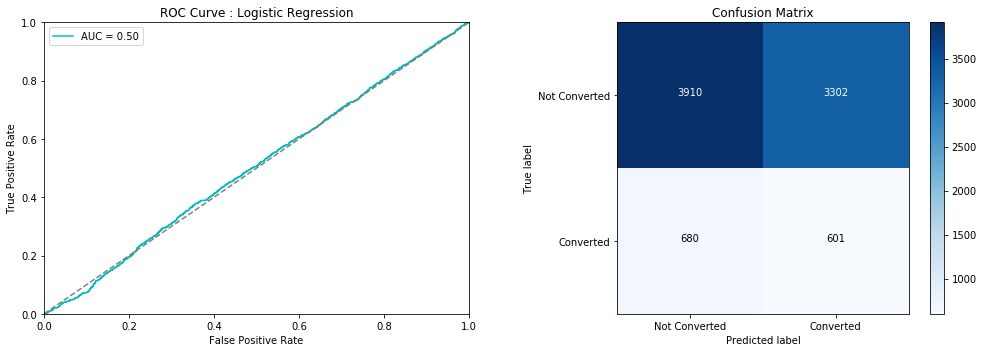

             precision    recall  f1-score   support

   visitors       0.85      0.54      0.66      7212
     Buyers       0.15      0.47      0.23      1281

avg / total       0.75      0.53      0.60      8493



In [87]:
# Create Logistic Regression Model
# We are using class_weight to be balanced so that weights are adjusted as per output class proportion
model = LogisticRegression(class_weight='balanced', random_state=99)
model_lr, fpr_lr, tpr_lr, auc_lr = Model_Report(model,'Logistic Regression', X_train, y_train, X_test, y_test)

Model :  Random Forest
Model Report
Test Accuracy : 0.78
Test AUC :0.50


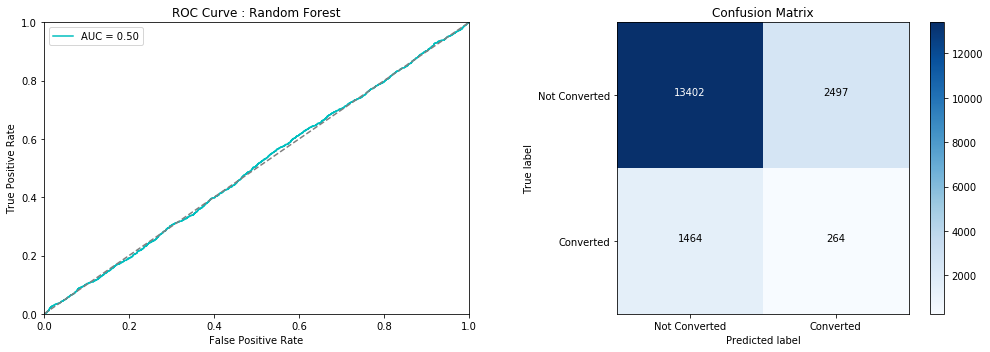

             precision    recall  f1-score   support

   visitors       0.90      0.84      0.87     15899
     Buyers       0.10      0.15      0.12      1728

avg / total       0.82      0.78      0.80     17627



In [63]:

model = RandomForestClassifier(random_state=99,n_estimators = 10,min_samples_leaf=100, class_weight='balanced')
model_rf, fpr_rf, tpr_rf, auc_rf = Model_Report(model,'Random Forest', X_train, y_train, X_test, y_test)

## Word Embeddings

In [35]:
from gensim.models import Word2Vec

In [36]:
# train model
model = Word2Vec(df_test['features'])

In [37]:
# summarize the loaded model
print(model)

Word2Vec(vocab=23, size=100, alpha=0.025)


In [38]:
# summarize vocabulary
words = list(model.wv.vocab)

In [39]:
print(words)

['homepage', 'vehiclenew', 'specifications', 'accessories', 'design', 'features', 'dealerfinder', 'directselling', 'contactus', 'offers', 'characteristics', 'performance', 'testdrive', 'selectvehicle', 'selectdealer', 'testdriveconfirmation', 'manuals', 'experience', 'others', 'warranty', 'pcd', 'periodicreview', 'services']


In [41]:
print(model['vehiclenew'])

[  1.93176135e-01  -8.10505807e-01   2.47006401e-01  -1.42927423e-01
  -4.29099321e-01  -5.30267879e-02   4.03574668e-04  -2.65440881e-01
   3.59653056e-01   2.38276228e-01   5.57534158e-01   2.43672401e-01
  -6.52929425e-01  -1.72729000e-01  -7.25569576e-02  -2.36851186e-01
  -2.81817466e-01   2.16679052e-01   1.27564237e-01   4.38337117e-01
  -3.26112658e-01   7.42170820e-03  -5.08978628e-02   2.18759820e-01
  -1.90164968e-01   3.57893348e-01   4.37918812e-01  -5.70148647e-01
   3.12233657e-01   3.46350551e-01   3.66084099e-01  -4.27795440e-01
   2.55788863e-02   3.29759985e-01  -2.77751386e-01   3.18462327e-02
  -1.81212544e-01   3.55157673e-01   2.62764785e-02  -6.93437338e-01
  -2.53659010e-01   5.29482186e-01  -2.88212985e-01   5.86108029e-01
   1.86107740e-01   7.13820755e-01   2.51812547e-01  -2.23107114e-01
  -7.18821362e-02   1.60312831e-01  -4.54970330e-01  -4.59379070e-02
  -8.56774449e-01  -4.97794271e-01   1.45525753e-01   6.46535873e-01
   5.70277870e-01  -2.88405389e-01

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [42]:
X=model[model.wv.vocab]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [43]:
X.shape

(23, 100)

## PCA 

In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

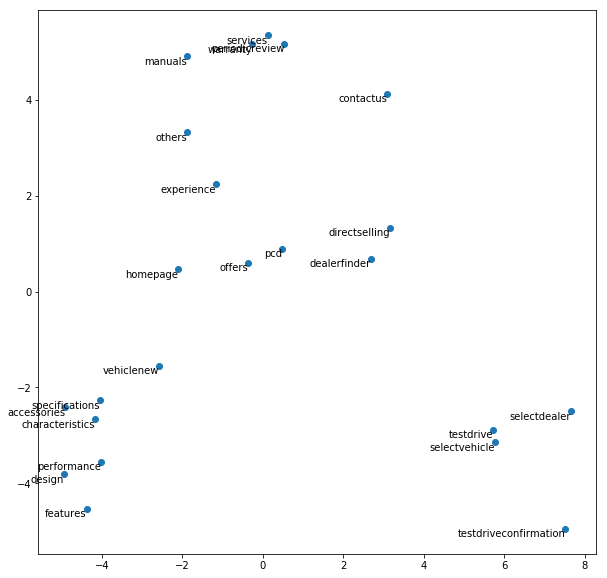

In [48]:
# plotting with words

# create a scatter plot of the projection
plt.figure(figsize=(10,10))
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)


for i,word in enumerate(words):
    
    plt.annotate(word,horizontalalignment='right', verticalalignment='top',xy=(result[i, 0], result[i, 1]))

plt.show()

# T-sne Plots

In [49]:
df_tsne=df_test.sample(7000)

In [50]:
df_tsne = df_tsne.reset_index(drop=True)

In [51]:
def label_sentences(df_tsne):
    labeled_sentences = []
    for index, datapoint in df_tsne.iterrows():
        tokenized_words = datapoint['features']
        labeled_sentences.append(LabeledSentence(words=tokenized_words, tags=['SENT_%s' %index]))
    return labeled_sentences

In [52]:
def train_doc2vec_model(labeled_sentences):
    model = Doc2Vec(min_count=1,alpha=0.025, min_alpha=0.025)
    model.build_vocab(labeled_sentences)

    
    return model

sen = label_sentences(df_tsne)
model = train_doc2vec_model(sen)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [53]:
def vectorize_comments(df_tsne,d2v_model):
    y = []
    comments = []
    for i in range(0,df_tsne.shape[0]):
        label = 'SENT_%s' %i
        comments.append(d2v_model.docvecs[label])
    df_tsne['vectorized_comments'] = comments
    
    return df_tsne

df_tsne = vectorize_comments(df_tsne,model)
print (df_tsne.head(2))

                                            features         output  Length  \
0  [vehiclenew, design, specifications, vehiclene...       homepage      18   
1  [dealerfinder, directselling, dealerfinder, di...  directselling       9   

                                 vectorized_comments  
0  [0.00454655, -0.00367942, 0.00179465, 0.002506...  
1  [0.000788649, 7.21791e-05, 0.00453595, -0.0003...  


In [54]:
df_tsne.head(10)

,features,output,Length,vectorized_comments
0,"[vehiclenew, design, specifications, vehiclene...",homepage,18,"[0.00454655, -0.00367942, 0.00179465, 0.002506..."
1,"[dealerfinder, directselling, dealerfinder, di...",directselling,9,"[0.000788649, 7.21791e-05, 0.00453595, -0.0003..."
2,"[offers, vehiclenew, design, specifications, d...",offers,6,"[-0.00273082, 0.00104955, -0.00150479, 0.00380..."
3,"[directselling, offers, directselling, homepag...",specifications,6,"[-0.00242426, 0.00216165, -0.00481924, -0.0001..."
4,"[homepage, offers, vehiclenew, characteristics...",experience,15,"[0.000628145, 0.00115879, 0.00301222, 0.004532..."
5,"[homepage, dealerfinder, homepage, contactus, ...",homepage,6,"[0.00464629, 3.04931e-05, 0.00339047, -0.00198..."
6,"[homepage, vehiclenew, specifications, homepag...",specifications,7,"[0.00226221, -0.00201379, 0.00233517, 0.002973..."
7,"[homepage, dealerfinder, testdrive, selectvehi...",dealerfinder,5,"[-0.0018301, 0.00425973, 0.00054143, 0.0014656..."
8,"[vehiclenew, homepage, vehiclenew, specificati...",dropped,6,"[-0.00348123, -0.00440645, -0.00307208, 6.0435..."
9,"[vehiclenew, homepage, vehiclenew, homepage, v...",vehiclenew,9,"[0.00212142, 0.0046394, 0.00107941, -0.0048653..."


In [55]:
len(df_tsne.vectorized_comments[0])

100

In [56]:
import pandas as pd

In [57]:
df_new=pd.DataFrame(df_tsne.vectorized_comments.values.tolist(), index= df_tsne.index)

In [58]:
df_new.shape

(7000, 100)

In [68]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=300)
tsne_results = tsne.fit_transform(df_new)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.025s...
[t-SNE] Computed neighbors for 7000 samples in 8.807s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.007365
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.915939
[t-SNE] Error after 300 iterations: 4.380549
t-SNE done! Time elapsed: 94.3802101612091 seconds


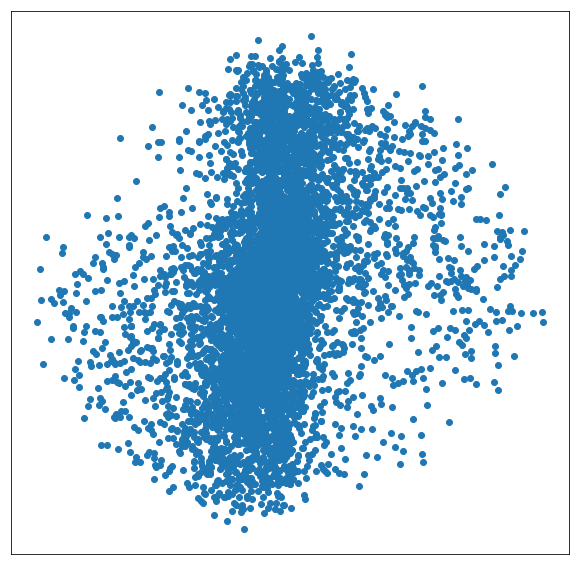

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

In [47]:
!pip install MulticoreTSNE

    100% |████████████████████████████████| 61kB 626kB/s ta 0:00:01
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [48]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [138]:
tsne = TSNE(n_jobs=4,perplexity=10,n_iter=300,n_jobs=)
Y = tsne.fit_transform(df_new)

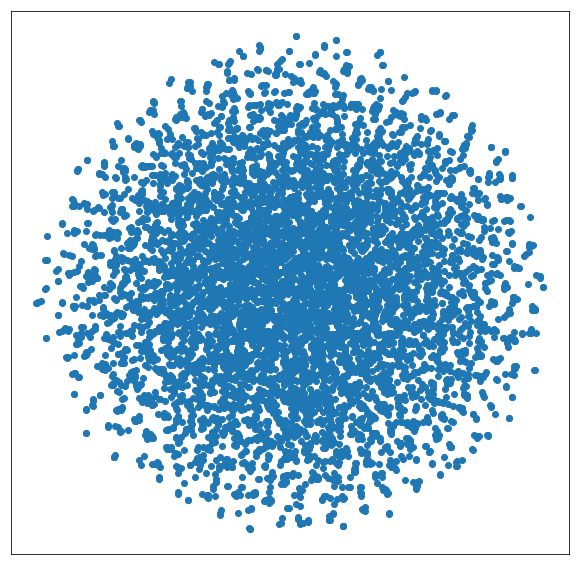

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.scatter(Y[:, 0], Y[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

In [26]:
len(pd_df[(pd_df.output == 'dropped')])

257496

In [27]:
import numpy as np

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split



Using TensorFlow backend.


In [29]:
#validating shape of final dataset
pd_df.shape

(680856, 3)

In [30]:
#creating max length variable
max_length=max(pd_df.Length)
print(max_length)

56


In [31]:
#using tokenizer to convert features into numerical vectors
tokenizer = Tokenizer(num_words=max_length, split=' ')
tokenizer.fit_on_texts(pd_df['processed_features'].values)
#creating sequence vectors 
X = tokenizer.texts_to_sequences(pd_df['processed_features'].values)
#padding to make each input vector of same length as max length 
X = pad_sequences(X,maxlen=max_length)

In [32]:
word_index=tokenizer.word_index
print(word_index)
len(word_index)

{'vehicle': 1, 'homepage': 2, 'promo': 3, 'form': 4, 'specifications': 5, 'others': 6, 'design': 7, 'finance': 8, 'features': 9, 'performance': 10, 'dealerfinder': 11, 'aftersales': 12, 'testdrive': 13, 'article': 14, 'press': 15, 'accessories': 16, 'career': 17, 'experience': 18, 'owners': 19, 'testdriveconfirmation': 20}


20

In [33]:
#validating shape of new df after tokenization
X.shape

(680856, 56)

In [33]:
X

array([[ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0, 17],
       [ 0,  0,  0, ...,  0,  0,  5],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  1,  5]], dtype=int32)

In [35]:
import pandas as pd

In [36]:
Y = pd.get_dummies(pd_df['output']).values
train_x, test_x, train_y, test_y = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(train_x.shape,train_y.shape)
print(test_x.shape,test_y.shape)

(510642, 56) (510642, 21)
(170214, 56) (170214, 21)


In [37]:
embed_dim = 100
lstm_out =100

model = Sequential()
model.add(Embedding(max_length, embed_dim,input_length = X.shape[1]))
model.add(Dense(100,activation='relu'))
model.add(LSTM(lstm_out, dropout_U=0.2, dropout_W=0.2))
model.add(Dense(21,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, dropout=0.2, recurrent_dropout=0.2)`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 56, 100)           5600      
_________________________________________________________________
dense_1 (Dense)              (None, 56, 100)           10100     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 21)                2121      
Total params: 98,221
Trainable params: 98,221
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
batch_size = 1000
model.fit(train_x, train_y, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
 - 446s - loss: 1.5602 - acc: 0.5003
Epoch 2/10
 - 431s - loss: 1.5542 - acc: 0.5008
Epoch 3/10
 - 444s - loss: 1.5497 - acc: 0.5019
Epoch 4/10
 - 452s - loss: 1.5467 - acc: 0.5030
Epoch 5/10
 - 437s - loss: 1.5440 - acc: 0.5034
Epoch 6/10
 - 466s - loss: 1.5419 - acc: 0.5043
Epoch 7/10
 - 508s - loss: 1.5402 - acc: 0.5041
Epoch 8/10
 - 470s - loss: 1.5388 - acc: 0.5048
Epoch 9/10
 - 407s - loss: 1.5374 - acc: 0.5050
Epoch 10/10
 - 425s - loss: 1.5361 - acc: 0.5053


In [40]:
score,acc = model.evaluate(test_x, test_y, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 1.54
acc: 0.50


In [43]:
predictions=model.predict(test_x)
predictions=np.argmax(predictions,axis=1)

## Plot confusion matrix

In [42]:
import numpy as np

In [44]:
from sklearn.metrics import confusion_matrix,classification_report

In [45]:
print(confusion_matrix(np.argmax(test_y,axis=1),predictions))

[[   16     0     0     0     0    17   484     0    52     2     0    14
      0     0    38     0     3    78     0     0   152]
 [    0   359     3     1    14     6  1131     4     6     9     7    75
     79     7     6     1    38    11     1     0   847]
 [    1    11    87     0     1     1   204     1     3     2     0     7
      3     0     0     0     5     1     0     0   193]
 [    0     5     1    59     0     0   300     1     1     3     3    33
      5     1     1     1    21     3     0     0   292]
 [    2    33     5     4   115     3  1966     1     8    41    15    91
     53     1     6     0   105    18     8     0  1007]
 [    1     1     1     0     0   363  3359     0    75   110    24   136
      1     0   211     0     4   360     0     0   542]
 [    6   197    47    60    64   264 46196    18   701   595    89   956
    353    13   349     3  1034   923     1     0 12344]
 [    0     9     1     4     2     2   294    77     1    10     1    31
      4  

In [46]:
print(classification_report(np.argmax(test_y,axis=1),predictions))

             precision    recall  f1-score   support

          0       0.40      0.02      0.04       856
          1       0.42      0.14      0.21      2605
          2       0.43      0.17      0.24       520
          3       0.33      0.08      0.13       730
          4       0.32      0.03      0.06      3482
          5       0.31      0.07      0.11      5188
          6       0.50      0.72      0.59     64213
          7       0.60      0.12      0.19       667
          8       0.48      0.52      0.50      4465
          9       0.38      0.21      0.27      5283
         10       0.25      0.01      0.02     10192
         11       0.35      0.19      0.24      7836
         12       0.53      0.32      0.39      3343
         13       0.76      0.23      0.36       416
         14       0.53      0.44      0.48      3561
         15       0.40      0.00      0.01      1208
         16       0.49      0.18      0.27     12034
         17       0.51      0.34      0.41   

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
encode=np.argmax(Y[:][:],axis=1)

In [48]:
look_up_target=pd_df['output'][:]

In [49]:
dic=dict(zip(encode,look_up_target))

In [51]:
dic

{0: 'accessories',
 1: 'aftersales',
 2: 'article',
 3: 'career',
 4: 'dealerfinder',
 5: 'design',
 6: 'dropped',
 7: 'experience',
 8: 'features',
 9: 'finance',
 10: 'form',
 11: 'homepage',
 12: 'others',
 13: 'owners',
 14: 'performance',
 15: 'press',
 16: 'promo',
 17: 'specifications',
 18: 'testdrive',
 19: 'testdriveconfirmation',
 20: 'vehicle'}